In this notebook, we want to summarize the data and make sure that it is behaving as we expect based on previous literature. Here, we want to only use the outcome for tumor_cell_evaluation

Tumor score is defined by UCSF pathologists in the following way: <br>

0: neuropil without tumor <br>
1: infiltrating tumor margin containing a detectable but not abundant number of tumor cells <br>
2: more cellular infiltrated zone <br>
3: highly cellular tumor <br>

In [4]:
recgli = read.csv("../../ParseData/8thParse_researchPath_withInVivo.csv") 

#### In this notebook, we want to find: <br>
1. Anatomical params vs. TS using <br>
    a. No separation into ROIs <br>
    b. Visual comparison of anatomical params in separate regions <br>
    ~~c. Repeated Measures ANOVA (analysis of variance) to account for multiple samples from the same patient to see if there is true separation among tumor scores for anatomical parameters~~ <b> you can't use RMANOVA for categorical data </b> (sources: http://sherifsoliman.com/2014/12/10/ANOVA_in_R/, https://www.r-bloggers.com/two-way-anova-with-repeated-measures/, https://www.r-statistics.com/tag/ezanova/) <br> 
    c. Use GLMM associate anatomical parameters with TS, no separation <br>
    d. Use GEE to associate anatomical parameters with TS, no separation <br>
    e. Use GLMM to associate anatomical parameters with TS, separating into CEL & NEL <br>
    f. Use GEE to associate anatomical parameters with TS, separating into CEL & NEL <br>

2. Combining anat params vs. TS using GEE <br>
3. Using in_CEL as a covariate in anat params using GEE <br>
4. Using RM ANOVA to use imaging characteristics as the dependent variable, and the TS as independent variable 

## 0. Prep the data

In [3]:
colnames(recgli)

[1] "b_number"                  "t_number"                 
 [3] "sf_number"                 "current_scan_date"        
 [5] "current_surgery_date"      "current_hist_grade"       
 [7] "current_hist_type"         "roi.label"                
 [9] "tumor_cell_evaluation"     "necrosis"                 
[11] "f8_delicate"               "f8_simple"                
[13] "f8_complex"                "mib_1"                    
[15] "bx_pure_treatment_effect"  "nfse"                     
[17] "nfl"                       "nt1c"                     
[19] "nt1v"                      "nadc.1"                   
[21] "nfa.1"                     "nev1.1"                   
[23] "nev2.1"                    "nev3.1"                   
[25] "nevrad.1"                  "nadc.2"                   
[27] "nfa.2"                     "nev1.2"                   
[29] "nev2.2"                    "nev3.2"                   
[31] "nevrad.2"                  "cbvn_nlin"                
[33] "phn_nlin"                  "phn_npar"                 
[35] "recovn_npar"               "cni"                      
[37] "ccri"                      "crni"                     
[39] "ncho"                      "ncre"                     
[41] "nnaa"                      "nlip"                     
[43] "laclip"                    "nlac"                     
[45] "olddata"                   "newdata"                  
[47] "comments"                  "notes."                   
[49] "imaging_code"              "perf_quant"               
[51] "spec_quant"                "include_anat"             
[53] "include_diffu1000"         "include_diffu2000"        
[55] "include_diffu_all"         "include_perf"             
[57] "include_spec"              "include_one_advanced_mod" 
[59] "include_all_advanced_mods" "X.CEL"                    
[61] "X.NEL"                     "X.NEC"                    
[63] "sum"                       "in_CEL"                   
[65] "in_T2all"                  "in_NEL"                   
[67] "in_NEC"                    "in_ROI"                   
[69] "desired_hist"              "multnom_out"              
[71] "no_ffpe"                   "waiting_on_path"          
[73] "rhgg_txe_analysis"

The first thing we have to do is actually take away those that were "indeterminable" when tumor score was evaluated by the pathologist: 

In [4]:
table(recgli$tumor_cell_evaluation)


  0   1   2   3 Ind 
 90  54 117 122   8 

In [5]:
recgli = recgli[recgli$tumor_cell_evaluation != "Ind",]
dim(recgli)
recgli = droplevels(recgli)
recgli$tumor_cell_evaluation = as.character(recgli$tumor_cell_evaluation)
recgli$tumor_cell_evaluation = as.numeric(recgli$tumor_cell_evaluation)
str(recgli$tumor_cell_evaluation)

[1] 383  73

 num [1:383] 0 2 2 2 0 1 0 2 1 0 ...


In [6]:
recgli.anat = recgli[recgli$include_anat==1,]
dim(recgli.anat)

[1] 383  73

In [7]:
recgli$t_number = as.factor(recgli$t_number)
#str(recgli)

## 1. Anatomical vs. TS 

### a. No separation into ROIs

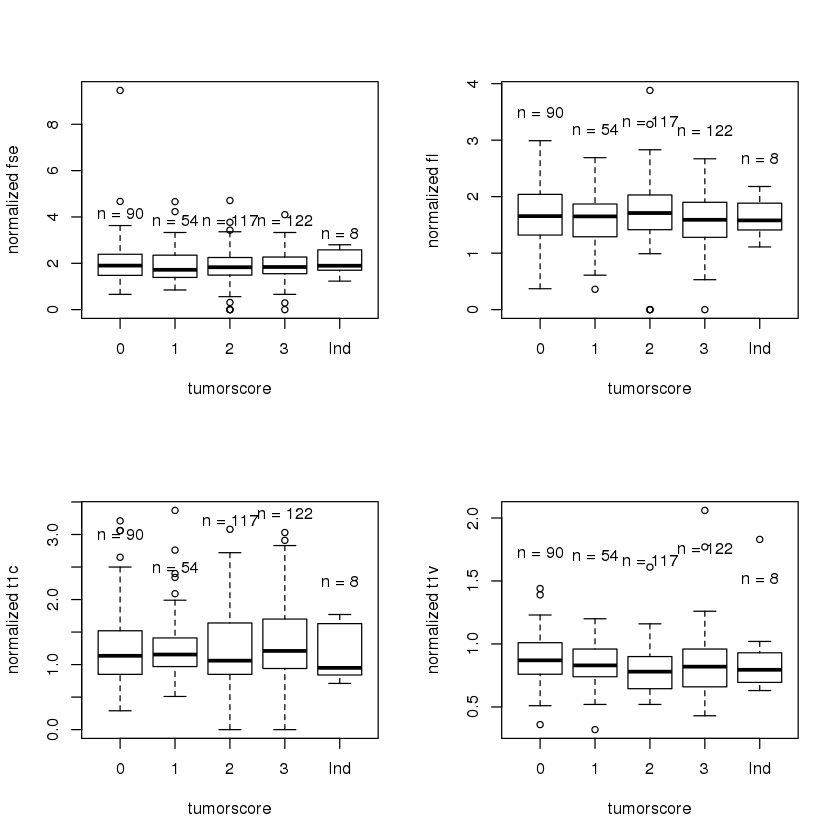

In [22]:
par(mfrow = c(2, 2))
a = boxplot(nfse ~ tumor_cell_evaluation , data = recgli, ylab = "normalized fse", xlab = "tumorscore")
text( c(1:nlevels(factor(recgli$tumor_cell_evaluation))) , a$stats[nrow(a$stats) , ]+0.5 , paste("n = ",table(recgli$tumor_cell_evaluation),sep="")  )

b = boxplot(nfl ~ tumor_cell_evaluation , data = recgli, ylab = "normalized fl", xlab = "tumorscore")
text( c(1:nlevels(factor(recgli$tumor_cell_evaluation))) , b$stats[nrow(b$stats) , ]+0.5 , paste("n = ",table(recgli$tumor_cell_evaluation),sep="")  )

c = boxplot(nt1c ~ tumor_cell_evaluation , data = recgli, ylab = "normalized t1c", xlab = "tumorscore")
text( c(1:nlevels(factor(recgli$tumor_cell_evaluation))) , c$stats[nrow(c$stats) , ]+0.5 , paste("n = ",table(recgli$tumor_cell_evaluation),sep="")  )

d = boxplot(nt1v ~ tumor_cell_evaluation , data = recgli, ylab = "normalized t1v", xlab = "tumorscore")
text( c(1:nlevels(factor(recgli$tumor_cell_evaluation))) , d$stats[nrow(d$stats) , ]+0.5 , paste("n = ",table(recgli$tumor_cell_evaluation),sep="")  )


### b. CEL next to NEL scores  

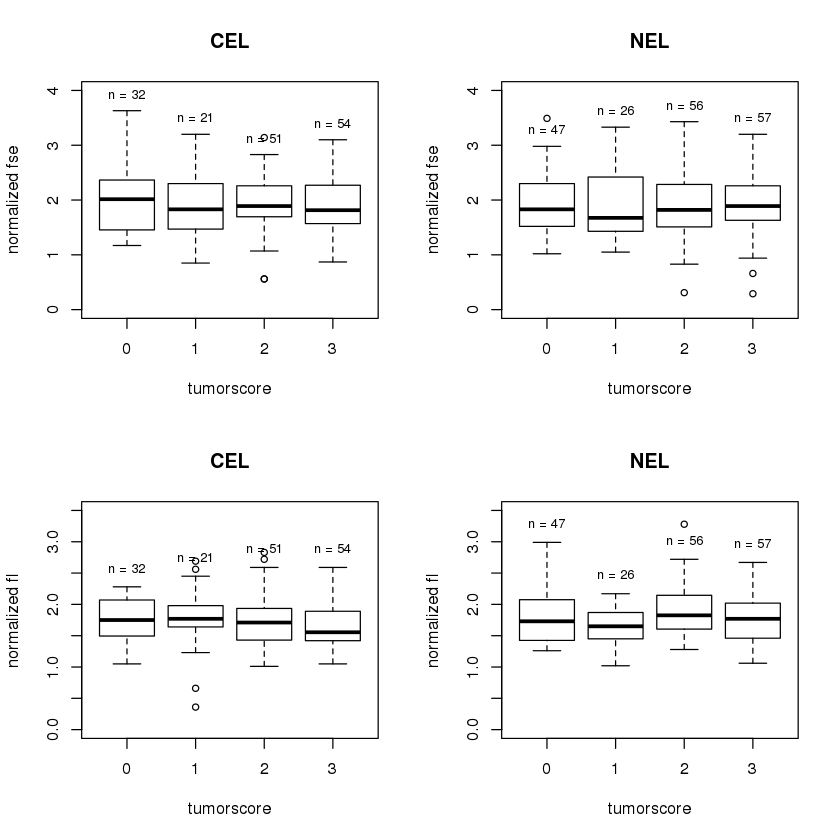

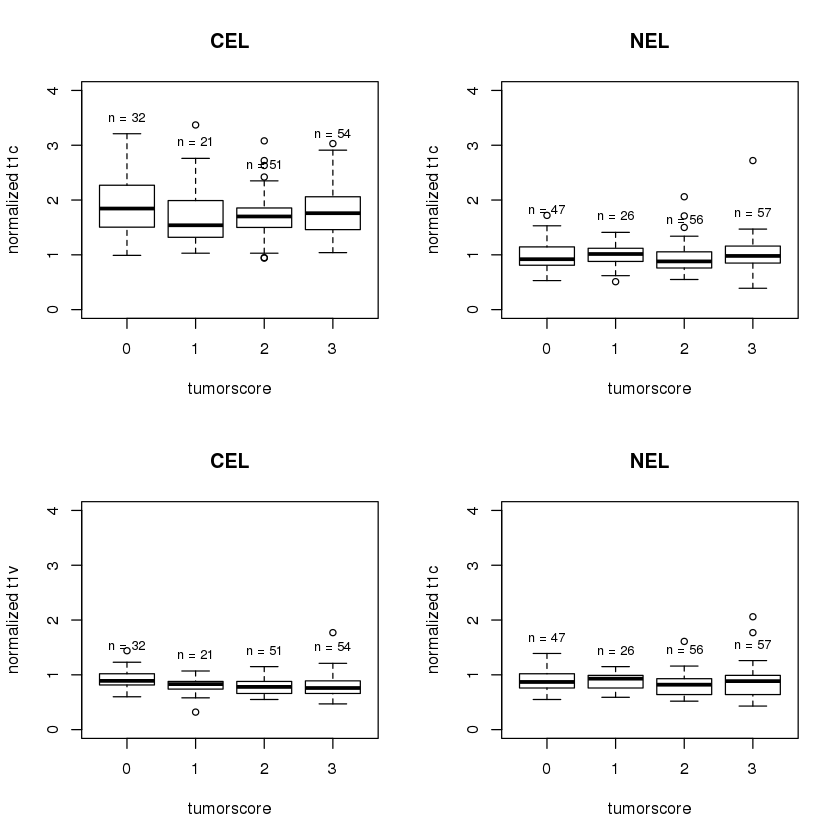

In [20]:
par(mfrow = c(2, 2))
a = boxplot(nfse ~ tumor_cell_evaluation , data = recgli[recgli$in_CEL ==1,], ylab = "normalized fse", xlab = "tumorscore", main = "CEL", ylim = c(0,4))
text( c(1:nlevels(factor(recgli$tumor_cell_evaluation))) , a$stats[nrow(a$stats) , ]+.3 , paste("n = ",table(recgli[which(recgli$in_CEL ==1),]$tumor_cell_evaluation),sep=""), cex = 0.8)

b = boxplot(nfse ~ tumor_cell_evaluation , data = recgli[recgli$in_NEL ==1,], ylab = "normalized fse", xlab = "tumorscore", main = "NEL", ylim = c(0,4))
text( c(1:nlevels(factor(recgli$tumor_cell_evaluation))) , b$stats[nrow(b$stats) , ]+.3 , paste("n = ",table(recgli[which(recgli$in_NEL ==1),]$tumor_cell_evaluation),sep=""), cex = 0.8)

c = boxplot(nfl ~ tumor_cell_evaluation , data = recgli[recgli$in_CEL ==1,], ylab = "normalized fl", xlab = "tumorscore", main = "CEL", ylim = c(0,3.5))
text( c(1:nlevels(factor(recgli$tumor_cell_evaluation))) , c$stats[nrow(c$stats) , ]+.3 , paste("n = ",table(recgli[which(recgli$in_CEL ==1),]$tumor_cell_evaluation),sep=""), cex = 0.8)
d = boxplot(nfl ~ tumor_cell_evaluation , data = recgli[recgli$in_NEL ==1,], ylab = "normalized fl", xlab = "tumorscore", main = "NEL", ylim = c(0,3.5))
text( c(1:nlevels(factor(recgli$tumor_cell_evaluation))) , d$stats[nrow(d$stats) , ]+.3 , paste("n = ",table(recgli[which(recgli$in_NEL ==1),]$tumor_cell_evaluation),sep=""), cex = 0.8)

e = boxplot(nt1c ~ tumor_cell_evaluation , data = recgli[recgli$in_CEL ==1,], ylab = "normalized t1c", xlab = "tumorscore", main = "CEL", ylim = c(0,4))
text( c(1:nlevels(factor(recgli$tumor_cell_evaluation))) , e$stats[nrow(e$stats) , ]+.3 , paste("n = ",table(recgli[recgli$in_CEL ==1,]$tumor_cell_evaluation),sep=""), cex = 0.8)
f = boxplot(nt1c ~ tumor_cell_evaluation , data = recgli[recgli$in_NEL ==1,], ylab = "normalized t1c", xlab = "tumorscore", main = "NEL", ylim = c(0,4))
text( c(1:nlevels(factor(recgli$tumor_cell_evaluation))) , f$stats[nrow(f$stats) , ]+.3 , paste("n = ",table(recgli[recgli$in_NEL ==1,]$tumor_cell_evaluation),sep=""), cex = 0.8)

g = boxplot(nt1v ~ tumor_cell_evaluation , data = recgli[recgli$in_CEL ==1,], ylab = "normalized t1v", xlab = "tumorscore", main = "CEL", ylim = c(0,4))
text( c(1:nlevels(factor(recgli$tumor_cell_evaluation))) , g$stats[nrow(g$stats) , ]+.3 , paste("n = ",table(recgli[recgli$in_CEL ==1,]$tumor_cell_evaluation),sep=""), cex = 0.8)
h = boxplot(nt1v ~ tumor_cell_evaluation , data = recgli[recgli$in_NEL ==1,], ylab = "normalized t1c", xlab = "tumorscore", main = "NEL", ylim = c(0,4))
text( c(1:nlevels(factor(recgli$tumor_cell_evaluation))) , h$stats[nrow(h$stats) , ]+.3 , paste("n = ",table(recgli[recgli$in_NEL ==1,]$tumor_cell_evaluation),sep=""), cex = 0.8)


There is no package with a straightforward implementation of a multinomial logistic regression with mixed effects in R. Packages w/ mixed effects modeling for logistic regression include lme4, glmm; Packages w/ multinomial log reg include mlogit. 

### c. Use GLMM associate anatomical parameters with TS, no separation 

In [8]:
## I will come back to this later. 

### d. Use GEE to associate anatomical parameters with TS, no separation

In [9]:
library(glmnet)
library(geepack)
library(lme4)
#install.packages("multgee")
library("multgee")

Loading required package: Matrix
Loading required package: foreach
Loaded glmnet 2.0-16

Loading required package: gnm
Loading required package: VGAM
Loading required package: stats4
Loading required package: splines


In [26]:
#nfse.fit = geeglm(tumor_cell_evaluation ~ nfse, data = recgli, id = t_number, corstr = "exchangeable")
#anova(nfse.fit)

nfse.fit = ordLORgee(formula = tumor_cell_evaluation ~ nfse, link = "logit", 
                      id = t_number, data = recgli, LORstr = "category.exch")
summary(nfse.fit)$coefficients

,Estimate,san.se,san.z,Pr(>|san.z|)
beta10,-1.20100,0.28409,-4.22755,0.00002
beta20,-0.54916,0.27312,-2.01068,0.04436
beta30,0.73916,0.26321,2.80830,0.00498
nfse,0.00249,0.13007,0.01913,0.98474


In [27]:
nfl.fit = ordLORgee(formula = tumor_cell_evaluation ~ nfl, link = "logit", 
                      id = t_number, data = recgli, LORstr = "category.exch")
summary(nfl.fit)$coefficients

,Estimate,san.se,san.z,Pr(>|san.z|)
beta10,-1.07602,0.28743,-3.74359,0.00018
beta20,-0.43267,0.28023,-1.54398,0.12259
beta30,0.86553,0.27351,3.16449,0.00155
nfl,-0.07777,0.14118,-0.55088,0.58172


In [28]:
nt1c.fit = ordLORgee(formula = tumor_cell_evaluation ~ nt1c, link = "logit", 
                      id = t_number, data = recgli, LORstr = "category.exch")
summary(nt1c.fit)$coefficients

,Estimate,san.se,san.z,Pr(>|san.z|)
beta10,-1.33106,0.24358,-5.46465,0.00000
beta20,-0.69825,0.23436,-2.97940,0.00289
beta30,0.57859,0.23207,2.49316,0.01266
nt1c,0.12447,0.14702,0.84665,0.39719


In [37]:
nt1v.fit = ordLORgee(formula = tumor_cell_evaluation ~ nt1v, link = "logit", 
                      id = t_number, data = recgli, LORstr = "category.exch")
summary(nt1v.fit)$coefficients

[1] 383  73

### e. Use GLMM to associate anatomical parameters with TS, separating into CEL & NEL 

In [1]:
## need to come back to when becomes more obvious how to do GLMM with multinomial outcome... 
##can do this using a one-v-all method 

### f. Use GEE to associate anatomical parameters with TS, separating into CEL & NEL 

In [33]:
recgli_inCEL = recgli[which(recgli$in_CEL == 1),]
dim(recgli_inCEL)
is.numeric(recgli_inCEL$tumor_cell_evaluation)
head(recgli_inCEL)

[1] 158  73

[1] TRUE

,b_number,t_number,sf_number,current_scan_date,current_surgery_date,current_hist_grade,current_hist_type,roi.label,tumor_cell_evaluation,necrosis,⋯,in_CEL,in_T2all,in_NEL,in_NEC,in_ROI,desired_hist,multnom_out,no_ffpe,waiting_on_path,rhgg_txe_analysis
1,2723,6369,8122,9/13/09,9/14/09,Grade IV,Glioblastoma,10B28,0,0,⋯,1,1,0,0,1,1,TxE,0,0,1
2,2312,5317,7679,5/4/08,5/4/08,Grade IV,Glioblastoma,11B16,2,1,⋯,1,1,0,0,1,1,rHGG,0,0,1
4,2312,5317,7679,5/4/08,5/4/08,Grade IV,Glioblastoma,12B16,2,1,⋯,1,1,0,0,1,1,rHGG,0,0,1
6,2873,6709,8269,3/11/10,3/15/10,Grade IV,Glioblastoma,13B32,1,0,⋯,1,0,0,0,1,1,Ts1DNI,0,0,0
11,2222,6094,7758,8/3/08,8/4/08,Grade IV,Glioblastoma,15B18,0,0,⋯,1,1,0,0,1,1,TxE,0,0,1
13,2793,7584,8842,7/28/11,7/28/11,Grade IV,Glioblastoma,15B44,2,1,⋯,1,0,0,0,1,1,rHGG,0,0,1


In [42]:
coef_init = summary(nfse.fit)$coefficients[,1]

 Named num [1:4] -1.201 -0.54916 0.73916 0.00249
 - attr(*, "names")= chr [1:4] "beta10" "beta20" "beta30" "nfse"


In [23]:
nfse.fit2 = ordLORgee(formula = tumor_cell_evaluation ~ nfse, link = "logit", 
                      id = t_number, data = recgli_inCEL, LORstr = "category.exch", 
                    bstart = coef_init)
## for some reason this throws an error, I reported to the github and hope that there is a resolution of this issue 

ERROR: Error in ordLORgee(formula = tumor_cell_evaluation ~ nfse, link = "logit", : could not find function "ordLORgee"


In [24]:
head(recgli)

b_number,t_number,sf_number,current_scan_date,current_surgery_date,current_hist_grade,current_hist_type,roi.label,tumor_cell_evaluation,necrosis,⋯,in_CEL,in_T2all,in_NEL,in_NEC,in_ROI,desired_hist,multnom_out,no_ffpe,waiting_on_path,rhgg_txe_analysis
2723,6369,8122,9/13/09,9/14/09,Grade IV,Glioblastoma,10B28,0,0,⋯,1,1,0,0,1,1,TxE,0,0,1
2312,5317,7679,5/4/08,5/4/08,Grade IV,Glioblastoma,11B16,2,1,⋯,1,1,0,0,1,1,rHGG,0,0,1
3169,7540,8796,6/19/11,6/20/11,Grade IV,Glioblastoma,11B43,2,0,⋯,0,1,1,0,1,1,rHGG,0,0,1
2312,5317,7679,5/4/08,5/4/08,Grade IV,Glioblastoma,12B16,2,1,⋯,1,1,0,0,1,1,rHGG,0,0,1
2379,5950,7930,1/25/09,1/26/09,Treatment Effect,Treatment Effect,12B22,0,0,⋯,0,1,1,0,1,1,TxE,0,0,1
2873,6709,8269,3/11/10,3/15/10,Grade IV,Glioblastoma,13B32,1,0,⋯,1,0,0,0,1,1,Ts1DNI,0,0,0


## 2. Combining anatomical parameters to look at different associations within the GEE model: 

In [42]:
#library(multgee)
recgli$tumor_cell_evaluation = as.character(recgli$tumor_cell_evaluation)
recgli$tumor_cell_evaluation = as.numeric(recgli$tumor_cell_evaluation)
anat.fit = ordLORgee(formula = tumor_cell_evaluation ~ nfse+nfl+nt1c+nt1v, link = "logit", 
                      id = t_number, data = recgli, LORstr = "category.exch")
summary(anat.fit)$coefficients

,Estimate,san.se,san.z,Pr(>|san.z|)
beta10,-2.43741,0.70239,-3.47015,0.00052
beta20,-1.75926,0.68590,-2.56490,0.01032
beta30,-0.60042,0.65960,-0.91027,0.36268
nfse,0.14893,0.12474,1.19391,0.23251
nfl,-0.22804,0.20551,-1.10961,0.26717
nt1c,0.14363,0.17462,0.82251,0.41079
nt1v,1.41215,0.73258,1.92765,0.05390


## 3. Using in_CEL as a covariate in anat params using GEE 

In [43]:
anat.cel.fit = anat.fit = ordLORgee(formula = tumor_cell_evaluation ~ nfse+nfl+nt1c+nt1v*in_CEL, link = "logit", 
                      id = t_number, data = recgli, LORstr = "category.exch")

In [44]:
summary(anat.cel.fit)$coefficients

,Estimate,san.se,san.z,Pr(>|san.z|)
beta10,-1.83319,0.79214,-2.31421,0.02066
beta20,-1.14865,0.77857,-1.47533,0.14012
beta30,0.01321,0.76590,0.01724,0.98624
nfse,0.11687,0.12270,0.95245,0.34087
nfl,-0.24227,0.21193,-1.14314,0.25298
nt1c,0.26908,0.21528,1.24992,0.21133
nt1v,0.74862,0.86585,0.86460,0.38726
in_CEL,-1.61603,0.95874,-1.68557,0.09188
nt1v:in_CEL,1.64236,1.18348,1.38773,0.16522


## 4. Using RM ANOVA to use imaging characteristics as the dependent variable, and the TS as independent variable 

In [13]:
library(ez)
table(is.na(recgli$tumor_cell_evaluation))


FALSE 
  391 

In [20]:
nfse.anova.fit = ezANOVA(data = recgli,
                        dv = nfse, 
                        wid = t_number, 
                        within = .(tumor_cell_evaluation),
                        )

Warning message:
“Converting "t_number" to factor for ANOVA.”Warning message:
“Collapsing data to cell means. *IF* the requested effects are a subset of the full design, you must use the "within_full" argument, else results may be inaccurate.”

ERROR: Error in ezANOVA_main(data = data, dv = dv, wid = wid, within = within, : One or more cells is missing data. Try using ezDesign() to check your data.
